# Analysis of results from Toloka survey

In [117]:
# Imports and installs
!pip3 install python-Levenshtein
import pandas as pd
import numpy as np 
import datetime
import json
import Levenshtein

# raw = pd.read_json("data/kym.json")        # meme templates from Know Your Meme, 16 features
# events = pd.read_json("data/events.json")  # memes with timestamps from origin and spread

# Q1: Have you used this meme before?
# Q2: Have you seen others use this meme?
# Q3: Do you relate to this meme?

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


### Select relevant columns and clean data

In [101]:
results = pd.read_csv("data/toloka_results.tsv", sep="\t")
results = results.drop(columns=['INPUT:image', 'OUTPUT:captcha', 'OUTPUT:text_review_mode', 'GOLDEN:q1', 'GOLDEN:q2', 'GOLDEN:q3', 'GOLDEN:result', 'GOLDEN:captcha', 'GOLDEN:reaction', 'GOLDEN:snowclone', 'GOLDEN:exploitable', 'GOLDEN:text_review_mode', 'HINT:text', 'HINT:default_language', 'ASSIGNMENT:link', 'ASSIGNMENT:task_id', 'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id', 'ASSIGNMENT:status'])
results['OUTPUT:result'] = results['OUTPUT:result'].apply(lambda x: json.loads(x))

# Convert multiple-choice answers to boolean
results['OUTPUT:q1'] = results['OUTPUT:q1'].map({'1y': True, '1n': False})
results['OUTPUT:q2'] = results['OUTPUT:q2'].map({'2y': True, '2n': False})
results['OUTPUT:q3'] = results['OUTPUT:q3'].map({'3y': True, '3n': False})

# Calculate time taken per assignment
results['ASSIGNMENT:submitted'] = pd.to_datetime(results['ASSIGNMENT:submitted'])
results['ASSIGNMENT:started'] = pd.to_datetime(results['ASSIGNMENT:started'])
results['minutes_taken'] = results['ASSIGNMENT:submitted'] - results['ASSIGNMENT:started']
results['minutes_taken'] = results['minutes_taken'].apply(lambda x: round(x.total_seconds() / 60, 2))
results = results.drop(columns=['ASSIGNMENT:started', 'ASSIGNMENT:submitted'])

results.head()

,INPUT:input,INPUT:memelink,OUTPUT:q1,OUTPUT:q2,OUTPUT:q3,OUTPUT:result,OUTPUT:reaction,OUTPUT:snowclone,OUTPUT:exploitable,minutes_taken
0,Autistic Screeching is an exploitable comic se...,https://knowyourmeme.com/memes/autistic-screec...,False,False,False,"{'Title': ['Autistic Screeching', '""autistic s...",False,True,False,8.59
1,"No Items, Fox Only, Final Destination is a cat...",https://knowyourmeme.com/memes/no-items-fox-on...,False,False,False,"{'Title': ['No Items, Fox Only, Final Destinat...",True,False,False,5.60
2,Lie Down / Try Not to Cry / Cry a Lot refers a...,https://knowyourmeme.com/memes/lie-down-try-no...,False,False,False,"{'Title': ['Lie Down', 'Try Not to Cry', 'Cry ...",True,False,False,2.71
3,Autistic Screeching is an exploitable comic se...,https://knowyourmeme.com/memes/autistic-screec...,False,False,False,"{'Title': ['Autistic Screeching'], 'Meaning': ...",True,False,False,6.74
4,Y'all Consider This A Date? refers to a series...,https://knowyourmeme.com/memes/yall-consider-t...,False,False,False,"{'Title': ['Y'all Consider This A Date?'], 'Me...",False,False,True,9.53


### Compare highlight similarity

In [108]:
annotations = {key:[] for key in set(results['INPUT:memelink'])}
for url, highlights in zip(results['INPUT:memelink'], results['OUTPUT:result']):
    annotations[url].append(highlights)

# Number of annotations for Meaning
num_annotations = {key:[] for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    num_annotations[key] = [len(x['Meaning']) if 'Meaning' in x.keys() else 0 for x in val]

# Rank the annotation similarity by standard deviation of NUMBER of annotations
std_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in num_annotations.items():
    std_annotations[key] = np.std(val)
std_annotations = dict(sorted(std_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of NUMBER of annotations (meaning):\n", std_annotations)

Standard deviation of NUMBER of annotations (meaning):
 {'https://knowyourmeme.com/memes/thats-where-youre-wrong-kiddo': 0.0, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 0.0, 'https://knowyourmeme.com/memes/ideal-gf': 0.0, 'https://knowyourmeme.com/memes/repost-if-x': 0.0, 'https://knowyourmeme.com/memes/ew-i-stepped-in-shit': 0.0, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 0.0, 'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/is-this-a-pigeon': 0.0, 'https://knowyourmeme.com/memes/bitches-love-smiley-faces': 0.0, 'https://knowyourmeme.com/memes/modern-society-parodies': 0.0, 'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/misinformationalized-you-hear-about-video-games': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/top-gun-hat': 0.4, 'https://knowyourmeme.com/memes/where-is-your-god-now': 0.4

In [115]:
# Rank the annotation similarity by standard deviation of AVERAGE LENGTH of annotations
length_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    avg_lengths = []
    for ann in val:
        avg = []
        if 'Meaning' in ann.keys():
            for highlight in ann['Meaning']:
                avg.append(len(highlight))
            avg_lengths.append(sum(avg) / len(avg))
        else:
            avg_lengths.append(0)
    length_annotations[key] = np.std(avg_lengths)
    
length_annotations = dict(sorted(length_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of AVERAGE LENGTH of annotations (meaning):\n", length_annotations)

Standard deviation of AVERAGE LENGTH of annotations (meaning):
 {'https://knowyourmeme.com/memes/modern-society-parodies': 4.758150901348127, 'https://knowyourmeme.com/memes/oh-you-love-x-name-every-y': 5.427706698044765, 'https://knowyourmeme.com/memes/pennywise-the-clown': 5.782732917920384, 'https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded': 12.077251342917394, 'https://knowyourmeme.com/memes/your-mother-and-i-will-always-love-you': 17.26962651593832, 'https://knowyourmeme.com/memes/ideal-gf': 18.24938355123263, 'https://knowyourmeme.com/memes/no-items-fox-only-final-destination': 18.30409790183608, 'https://knowyourmeme.com/memes/i-am-altering-the-deal': 18.993098161642237, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 21.30352083576797, 'https://knowyourmeme.com/memes/how-to-talk-to-short-people': 21.509067855209345, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 21.73844520659194, 'https://knowyourmeme.com/memes/cant-argue-with-that-technicall

In [166]:
# Rank the annotation similarity by Levenshtein distance of annotations
# strip from spaces probably? TODO
highlights = {key:[] for key in set(results['INPUT:memelink'])}
distances = {key:[] for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    ID = 0
    anns = []
    for ann in val:
        ID += 1
        if 'Meaning' in ann.keys():
            for a in ann['Meaning']:
                anns.append((ID, a))
        else:
            pass # Not taking into account missing annotations
    highlights[key] = anns


for key, val in highlights.items():
    lev = []
    for i in range(len(val) - 1):
        for j in range(i + 1, len(val)):
            ann1 = val[i]
            ann2 = val[j]
            if ann1[0] != ann2[0]:
                lev.append(Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-")))
    distances[key] = lev
            

print(distances)

{'https://knowyourmeme.com/memes/autistic-screeching': [102, 105, 119, 107, 204, 70, 112, 0, 87, 181, 89, 70, 17, 251, 92, 212, 87, 181, 268], 'https://knowyourmeme.com/memes/art-gallery-puking': [31, 139, 142, 120, 108, 111, 89, 3, 29], 'https://knowyourmeme.com/memes/desk-flip': [0, 91, 0, 42, 61, 89, 89, 89, 55, 81, 91, 0, 42, 61, 91, 84, 34, 61, 57], 'https://knowyourmeme.com/memes/thats-where-youre-wrong-kiddo': [118, 92, 108, 136, 26, 10, 18, 16, 44, 28], 'https://knowyourmeme.com/memes/coincidence-i-think-not': [0, 54, 0, 0, 54, 0, 0, 54, 54, 0], 'https://knowyourmeme.com/memes/ideal-gf': [7, 46, 27, 40, 39, 20, 33, 19, 6, 25], 'https://knowyourmeme.com/memes/what-are-you-watching': [2, 43, 91, 91, 79, 93, 93, 77, 73, 73, 57, 0, 16, 16], 'https://knowyourmeme.com/memes/top-gun-hat': [39, 39, 121, 0, 120, 120], 'https://knowyourmeme.com/memes/repost-if-x': [59, 19, 112, 50, 52, 90, 17, 131, 47, 107], 'https://knowyourmeme.com/memes/ew-i-stepped-in-shit': [8, 5, 66, 8, 3, 58, 0, 6

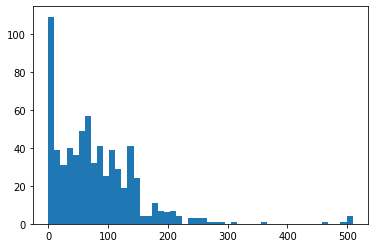

In [176]:
# Plot levenshtein distance histogram
import matplotlib.pyplot as plt
%matplotlib inline
hist_data = flat_list = [item for sublist in list(distances.values()) for item in sublist]
plt.hist(hist_data, bins = 50)
plt.show() 